In [89]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA, ARMA
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

warnings.filterwarnings('ignore')

In [90]:
df = pd.read_excel('./creprice_HousePriceData-master/Prices.xlsx', sheet_name='bj')

In [91]:
df

,时间(年-月),供给(元/㎡),关注(元/㎡),价值(元/㎡),供给(万元),关注(万元),供给(套),供给(㎡),关注(㎡),供给(年),关注(年)
0,2019-03-01,65253,62880,34250,753.5,792.6,57090,114.12,124.92,57,64
1,2019-02-01,65473,58102,34408,747.3,631.0,37322,114.05,101.50,57,66
2,2019-01-01,64663,57958,33774,730.2,594.3,42247,113.87,100.42,57,49
3,2018-12-01,63405,55919,33193,753.9,681.5,42976,116.33,119.57,57,55
4,2018-11-01,62298,72462,32983,745.4,931.0,42078,117.05,122.35,57,64
...,...,...,...,...,...,...,...,...,...,...,...
56,2014-07-01,37271,36102,22682,433.2,473.6,130044,113.66,125.23,49,49
57,2014-06-01,37605,36831,22498,437.6,506.9,156842,113.84,136.26,50,49
58,2014-05-01,38573,36032,22709,453.5,495.6,233774,115.33,138.29,51,45
59,2014-04-01,38537,36463,22893,447.8,498.0,159131,114.05,136.90,50,46


In [92]:
data = pd.DataFrame()
data['Timestamp'] = df.iloc[:,0]
data['price'] = df.iloc[:,1]
data = data.sort_values(by='Timestamp', ascending=True)
print(data)

    Timestamp  price
60 2014-03-01  40261
59 2014-04-01  38537
58 2014-05-01  38573
57 2014-06-01  37605
56 2014-07-01  37271
..        ...    ...
4  2018-11-01  62298
3  2018-12-01  63405
2  2019-01-01  64663
1  2019-02-01  65473
0  2019-03-01  65253

[61 rows x 2 columns]


In [93]:
data.Timestamp = pd.to_datetime(data.Timestamp)
data.index = data.Timestamp

In [94]:
# 数据探索
print(data)

            Timestamp  price
Timestamp                   
2014-03-01 2014-03-01  40261
2014-04-01 2014-04-01  38537
2014-05-01 2014-05-01  38573
2014-06-01 2014-06-01  37605
2014-07-01 2014-07-01  37271
...               ...    ...
2018-11-01 2018-11-01  62298
2018-12-01 2018-12-01  63405
2019-01-01 2019-01-01  64663
2019-02-01 2019-02-01  65473
2019-03-01 2019-03-01  65253

[61 rows x 2 columns]


In [95]:
# 设置参数范围
ps = range(0,10)
qs = range(0,10)
ds = range(1,5)
parameters = product(ps, ds, qs)
parameters_list = list(parameters)

In [96]:
# 寻找最优ARMA模型参数，best_aic最小
results = []
best_aic = float('inf') # 正无穷
for param in parameters_list:
    try:
        # SARIMAX 包含季节趋势因素的ARIMA模型
        model = sm.tsa.statespace.SARIMAX(data.price,
                                order=(param[0], param[1], param[2]),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [97]:
# 输出最优模型
print('最优模型:', best_model.summary())

最优模型:                            Statespace Model Results                           
Dep. Variable:                  price   No. Observations:                   61
Model:               SARIMAX(3, 4, 9)   Log Likelihood                -404.596
Date:                Fri, 24 Apr 2020   AIC                            835.193
Time:                        23:04:53   BIC                            859.245
Sample:                    03-01-2014   HQIC                           844.244
                         - 03-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5298      0.467     -3.277      0.001      -2.445      -0.615
ar.L2         -1.2044      0.626     -1.923      0.055      -2.432       0.023
ar.L3         -0.5772      0.399     -1.445   

In [100]:
# 设置future_month，需要预测的时间date_list
data_2 = data[['price']]
future_month = 3
last_month = pd.to_datetime(data_2.index[len(data_2)-1])
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= data.columns)
data_2 = pd.concat([data_2, future])

# get_prediction得到的是区间，使用predicted_mean
data_2['forecast'] = best_model.get_prediction(start=0, end=len(data_2)).predicted_mean

date_list= [Timestamp('2019-03-31 00:00:00'), Timestamp('2019-04-30 00:00:00'), Timestamp('2019-05-31 00:00:00')]


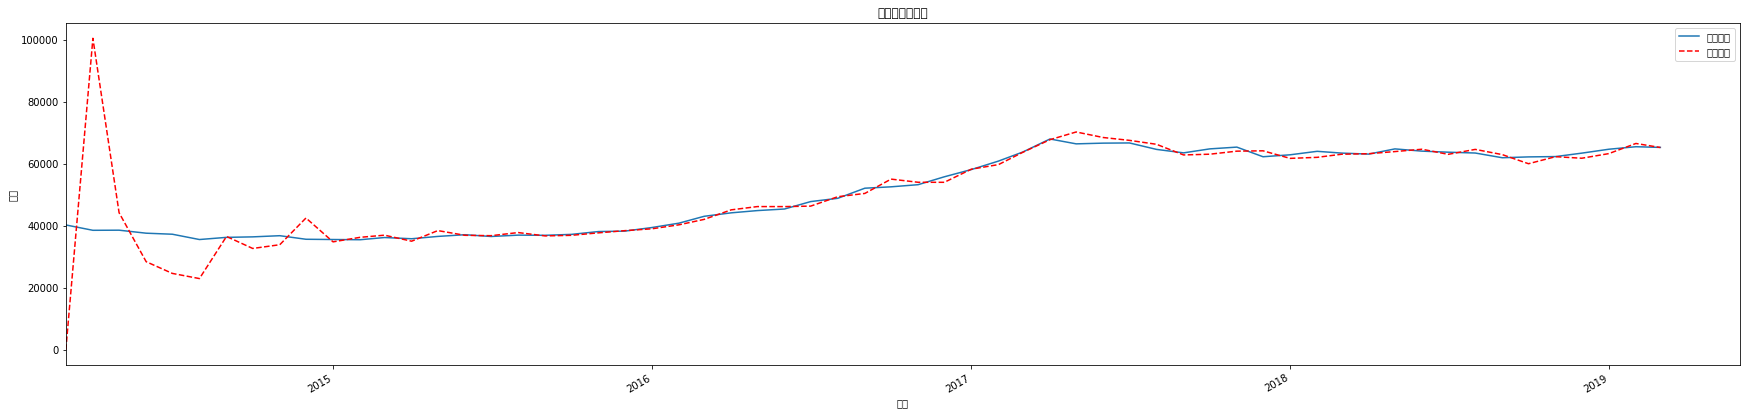

In [101]:
# 预测结果显示
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.figure(figsize=(30,7))
data_2.price.plot(label='实际房价')
data_2.forecast.plot(color='r', ls='--', label='预测房价')
plt.legend()
plt.title('北京房价（月）')
plt.xlabel('时间')
plt.ylabel('房价')
plt.show()